### Scenario 1: Tableau Dashboard Processing Code to Examine Mammal Habitat Richness by U.S. County

Our overarching goal is to advance the effectiveness of presenting scientific information using interactive<br>
web dashboards. The focus of the present work is to document the data processing steps used to construct a Tableau<br>
dashboard visualization examining mammal species richness per U.S. county. This Jupyer Notebook describes<br>
the I/O and basic data processing steps used to construct data files for the dashboard.<br>

Input: requires a geojson file of spatial boundaries (e.g. U.S. counties, ecoregions, etc.) and<br>
an overlapping single-band raster which stores the target data. The code should be able to process<br>
*.geojson files of polygon features and raster files for other applications with<br>
minor modifications.<br>

Analyses: multiple zonal statistics are calculated for each polygon feature. A sub-feature (sub-polygon)<br> 
histogram (or pdf) is generated to record the distribution of raster values in each feature.<br> 
Coordinates are auto converted to WGS84 (standard for geojson). The input raster grid can be upscaled or<br>
downscaled as appropriate. Low-level chunking is activated. The code is written in a cell-by-cell format<br>
but the code processing steps should be apparent.<br>

Output: a modified geojson file is created with raster statistics. A linked table is generated for<br> 
recording the sub-feature raster value distribution (histogram/pdf). At present, input and output files<br>
are read from and written to local disk.<br>

T. Wellman<br>
BioLab Team, Core Science Systems<br>
U.S. Geological Survey

In [1]:
import gdal
import osr, ogr
import json
import pandas as pd
from rasterstats import zonal_stats
import numpy as np
import csv
import time

In [2]:
# input files

# Geojson file of U.S. Counties - simplified from a U.S. Census shapefile and converted to geojson
# which is stored with this notebook for reproducibility
# Shapfile original data source + metadata: https://www2.census.gov/geo/tiger/GENZ2017/shp/cb_2017_us_county_500k.zip
choroplethGeojson = 'tl_2017_us_county_ESPG4326.geojson'
    
# Statistics to evaluate as string of statistics labels (see rasterstats docs, self explanatory)
stats2calc = "count min mean max median sum std nodata unique"

# Linking measure (parameter) to perform normalize calculations (min-max, mean-std normalizations) 
targetMeasure = 'ZONALSTATS.mean'


# TEST FILE :
# Data set from USGS GAP Mammal Richness map of U.S.
# Data source + metadata -  https://www.sciencebase.gov/catalog/item/5bf2d7abe4b045bfcae0c04e 
#                       file: mammal_richness_habitat30m.tif
# 
input_raster = "/Users/twellman/movebank/QGIS/mammal_richness_habitat30m.tif"


In [3]:
# output files - a modified U.S. counties geojson file with raster stastics and linked table file 

# linked table filename and path - creates *.csv table, links to input choropleth geojson ("choroplethGeojson" above) 
# "linkField" is a variable in the choropleth geojson used to link to the table
TableFname = '/Users/twellman/Documents/BCB_misc/decision_making/data/mapshaperTest/ZonalHistogramsGAP.csv'
linkField = 'properties.GEOID'

# Output modified geojson with raster statistics, 
# adds fileMod to choroplethGeojson (input file name)
fileMod = '_MODwSTATS_USGSGAP'
modFile =  choroplethGeojson.rsplit('.')
modifiedFile = modFile[0] + fileMod + "." + modFile[1]


In [4]:
''' END OF IMPORTS/INFO/INPUTs/OUTPUTs '''

' END OF IMPORTS/INFO/INPUTs/OUTPUTs '

min-max -3.2044013443296304 10.586331523462285
[-3.20440134 -1.67209769 -0.13979404  1.39250961  2.92481326  4.45711692
  5.98942057  7.52172422  9.05402787 10.58633152] 

count of vals in orig test data set:  2000
count of of vals in hist:  2000


<BarContainer object of 10 artists>

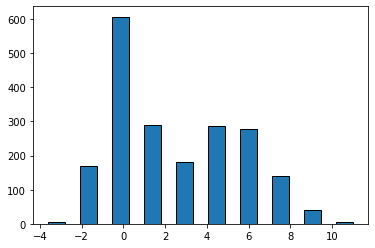

In [5]:
# Test numpy histogram function
# number of desired bins = "nbins" parameter + 1

import matplotlib.pyplot as plt

rng = np.random.RandomState(10)  # deterministic random data
data = np.hstack((rng.normal(size=1000),
                  rng.normal(loc=5, scale=2, size=1000)))

nbins = 9 
minV = np.min(data)
maxV = np.max(data)

incr = (maxV-minV)/nbins

vals, bins = np.histogram(data, bins=nbins+1, range = (minV-0.5*incr, maxV+0.5*incr), density=False)
binCenters = (bins[1:] + bins[:-1]) / 2

print('min-max', minV, maxV)
print(binCenters,'\n')
print('count of vals in orig test data set: ', sum(vals))
print('count of of vals in hist: ', len(data))

plt.bar(binCenters, vals, edgecolor='black')


In [6]:
# Evaluate projecton of geojson feature file (choroplethGeojson), 
# reproject to WGS 84 coordinate system if needed.

gdal.UseExceptions()
choroplethGeojson = "tl_2017_us_county_ESPG4326.geojson"


# evaluate shapefile layer projection
driver = ogr.GetDriverByName('GeoJson')
dataset = driver.Open(choroplethGeojson)
layer = dataset.GetLayer()
geogcs = layer.GetSpatialRef().GetAttrValue('geogcs')
del driver, dataset, layer


if geogcs != "WGS 84":
    
    srcDS = gdal.OpenEx(choroplethGeojson)
    layerOpts = ['reproject = True', 'RFC7946=YES', 'WRITE_BBOX=']
    reproj_geojson = input_geojson.split('.geojson')[0] + "_ESPG4326.geojson"
    ds = gdal.VectorTranslate(reproj_geojson, srcDS=srcDS, dstSRS='EPSG:4326', reproject=True, format = 'GeoJSON', layerCreationOptions = layerOpts)
    del ds
    
    choroplethGeojson = reproj_geojson
    print('vector file was reprojected to WGS84 complete')
    
else:
    print('validated - vector file projection is in WGS84')

del geogcs

validated - vector file projection is in WGS84


GDAL translate options<br>
<br>
TranslateOptions(options=None, format=None, outputType=gdalconst.GDT_Unknown, bandList=None, maskBand=None, width=0, height=0, widthPct=0.0, heightPct=0.0, xRes=0.0, yRes=0.0, creationOptions=None, srcWin=None, projWin=None, projWinSRS=None, strict=False, unscale=False, scaleParams=None, exponents=None, outputBounds=None, metadataOptions=None, outputSRS=None, nogcp=False, GCPs=None, noData=None, rgbExpand=None, stats=False, rat=True, resampleAlg=None, callback=None, callback_data=None)
source code 
Create a TranslateOptions() object that can be passed to gdal.Translate()<br>
Keyword arguments are : <br>
  options --- can be be an array of strings, a string or let empty and filled from other keywords.<br>
  format --- output format ("GTiff", etc...)<br>
  outputType --- output type (gdalconst.GDT_Byte, etc...)<br>
  bandList --- array of band numbers (index start at 1)<br>
  maskBand --- mask band to generate or not ("none", "auto", "mask", 1, ...)<br>
  width --- width of the output raster in pixel<br>
  height --- height of the output raster in pixel<br>
  widthPct --- width of the output raster in percentage (100 = original width)<br>
  heightPct --- height of the output raster in percentage (100 = original height)<br>
  xRes --- output horizontal resolution<br>
  yRes --- output vertical resolution<br>
  creationOptions --- list of creation options<br>
  srcWin --- subwindow in pixels to extract: [left_x, top_y, width, height]<br>
  projWin --- subwindow in projected coordinates to extract: [ulx, uly, lrx, lry]<br>
  projWinSRS --- SRS in which projWin is expressed<br>
  strict --- strict mode<br>
  unscale --- unscale values with scale and offset metadata<br>
  scaleParams --- list of scale parameters, each of the form [src_min,src_max] or [src_min,src_max,dst_min,dst_max]<br>
  exponents --- list of exponentiation parameters<br>
  outputBounds --- assigned output bounds: [ulx, uly, lrx, lry]<br>
  metadataOptions --- list of metadata options<br>
  outputSRS --- assigned output SRS<br>
  nogcp --- ignore GCP in the raster<br>
  GCPs --- list of GCPs<br>
  noData --- nodata value (or "none" to unset it)<br>
  rgbExpand --- Color palette expansion mode: "gray", "rgb", "rgba"<br>
  stats --- whether to calculate statistics<br>
  rat --- whether to write source RAT<br>
  resampleAlg --- resampling mode<br>
  callback --- callback method<br>
  callback_data --- user data for callback<br>

In [7]:
# Functions to rescale raster grid and convert to WGS 84 coordinate system
# Raster reprojection uses GDAL warp and translate in VRT (virtual file format) and osr utility
# Need to ensure the raster input file aligns spatially with the geojson input file.
# Note: it is likely less problematic to reprocess an externally generated raster using GDAL 
# before performing zonal statistics (stats use GDAL backend). A new raster is therefore created
# by default. The if/else loop below can be used to bypass the default but requires greater 
# specification than "WGS 84" as currently is used.

# Identify coordinate system
src = gdal.Open(input_raster)
prj=src.GetProjection()
srs=osr.SpatialReference(wkt=prj)
geogcs = srs.GetAttrValue('geogcs')

# Set scaleFactor to upscale (>1)
# or downscale (<1) the input raster
# or = 1.0 uses existing grid resolution
scaleFactor = 3.0

print("Input raster spatial reference:\n{}\n".format(srs))

del src, prj, srs  

# if not geogcs or geogcs != "WGS 84" or scaleFactor != 1:

modFile =  input_raster.rsplit('.')
reproj_raster = modFile[0] + "_WGS84" + "." + modFile[1]
ds = gdal.Warp('', input_raster, dstSRS='EPSG:4326', format='VRT',outputType=gdal.GDT_Int16) 
gtranform =ds.GetGeoTransform()
xRes = gtranform[1]
yRes = -gtranform[5]

print("Input raster grid resolution (xRes, Yres):{} {}\n".format(xRes, yRes))

Goptions = gdal.TranslateOptions(gdal.ParseCommandLine("-of Gtiff -co COMPRESS=DEFLATE"), 
                                 xRes=xRes*scaleFactor, yRes=yRes*scaleFactor)
translate = gdal.Translate(reproj_raster, ds, options=Goptions) 
gtranform2 = translate.GetGeoTransform()
xRes2 = gtranform2[1]
yRes2 = -gtranform2[5]
srs2 = osr.SpatialReference(wkt=translate.GetProjection())

print("Output raster spatial reference:\n{}\n".format(srs2))
print("Output raster grid resolution (xRes, Yres):{} {}\n".format(xRes2, yRes2))

input_raster = reproj_raster

del ds,translate
    
#else:
#    print("\n{}". format('The input raster file meets projection and grid resolution specifications'))
    

Input raster spatial reference:
PROJCS["NAD_1983_Albers",
    GEOGCS["NAD83",
        DATUM["North_American_Datum_1983",
            SPHEROID["GRS 1980",6378137,298.257222101004,
                AUTHORITY["EPSG","7019"]],
            AUTHORITY["EPSG","6269"]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4269"]],
    PROJECTION["Albers_Conic_Equal_Area"],
    PARAMETER["latitude_of_center",23],
    PARAMETER["longitude_of_center",-96],
    PARAMETER["standard_parallel_1",29.5],
    PARAMETER["standard_parallel_2",45.5],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH]]

Input raster grid resolution (xRes, Yres):0.00032565198259450255 0.00032565198259450255

Output raster spatial reference:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257

In [8]:
# calculates histogram (density=False) or pdf (density=True) for raster values 
# within specified vector region
# integrates with Rasterstats zonal stats function
# number of bins = "nbins", bins denoted at bin centers
# "prec": output precision in sig digits, prec = 0 return integer as float
# output: a json-ified nested list

def getHistPdf(data, nbins=10, density=False, prec = 0):
    
    '''calculates histogram (density=False) or pdf (density=True) for raster values 
       within specified vector region to specified precision'''
    
    # numpy arrays can be masked ... translated to 1D unmasked values
    # it's possible no data may intersect feature
    dataAs1DArray = data.compressed()
    if dataAs1DArray.size == 0:
        return None
    
    minV = np.min(dataAs1DArray)
    maxV = np.max(dataAs1DArray)
    nbins = nbins-1
    incr = (maxV-minV)/nbins
    
    values, bins = np.histogram(dataAs1DArray, bins=nbins+1, range = (minV-0.5*incr, maxV+0.5*incr), density=False)
    valuesSig = [round(elem, prec) for elem in values]
    binCenters = (bins[1:] + bins[:-1]) / 2
    BinValAry = np.round( np.column_stack((binCenters,valuesSig)), decimals = prec)    
    return BinValAry.tolist()


# Create iterator to chunk list based on batch size (n records)

def chunks(mylist, n):
    
    length = len(mylist)
    for i in range(0, len(mylist), n):
        yield mylist[i:i+n], min(i+n,length)


# Calculates basic statistics (default = {count, min, mean, max, median, sum, std, nodata, unique}) 
# and custom calculations using zonal stats "add_stats" function. Calculations are performed per polygon feature.
# Returns updated geojson in memory 
    
def PolyStats(input_raster, choroplethGeojson,
              stats2calc = "count min mean max median sum std nodata unique",
              targetMeasure = 'ZONALSTATS.mean',
              batch_size = 999):

    '''Returns basic statistics (default = {count, min, mean, max, median, sum, std, nodata, unique}) 
       and custom functions using add_stats per polygon,  
       and normalized values using min-max and mean-std normalization
       Inputs: geojson choropleth defining subregions and input data raster 
       Assumes geojson properties are located in choropeths['features']['properties'] (standard)
    '''
 
    with open(choroplethGeojson) as response:
        choropleths = json.load(response)
        t0 = time.time()
        zoneStats = [] 
        features = choropleths['features'] 
        
        for chunk, maxI in chunks(features, batch_size):
            print("Chunk processing raster stats to poly feature {} / {} records".format(maxI, len(features)))        
            zstat = zonal_stats(chunk, input_raster, stats=stats2calc, add_stats={'getHistPdf': getHistPdf})
            zoneStats.extend(zstat)
            print('   processing time [secs]: ', round(time.time()-t0, 2))
        
        for gjsonObjProp, zs in zip(features, zoneStats):
            zsRn = {}
            for key in zs:
                zsRn["ZONALSTATS." + key] = zs[key]
            gjsonObjProp['properties'].update(zsRn)

        # calculate min-max and mean-stdev normalized values for specified target measure
        # only in regions with data (count > 0)
        targetVals = [dic['properties'][targetMeasure] for dic in features if dic['properties'][targetMeasure] is not None]
        maxOfPolyMeas = np.max(targetVals)
        minOfPolyMeas = np.min(targetVals)
        diffOfPolyMeas = maxOfPolyMeas-minOfPolyMeas
        avgOfPolyMeas = np.mean(targetVals)
        stdevOfPolyMeas = np.std(targetVals)
        for polygon in choropleths["features"]:
            Val = polygon['properties'][targetMeasure]
            if Val is not None:
                polygon['properties'][targetMeasure + 'NormMinMax'] = (Val-minOfPolyMeas)*100.0/diffOfPolyMeas
                polygon['properties'][targetMeasure + 'NormMeanStd'] = (Val-avgOfPolyMeas)/stdevOfPolyMeas
            else:
                polygon['properties'][targetMeasure + 'NormMinMax'] = None
                polygon['properties'][targetMeasure + 'NormMeanStd'] = None
                

        '''processing complete'''

        return choropleths

In [9]:
# Perform calculations - determine raster statistics and output to geojson
# json dump modified file to local disk for now
# Note: zero arrays (null values) occur where raster cells do not intersect a vector feature

# calculate raster statistics using geojson vector file
feature_collection = PolyStats(input_raster, choroplethGeojson, stats2calc, targetMeasure, 1000)


# Use returned feature collection either in memory or output local copy as geosjon file, shown here
with open(modifiedFile, 'w') as f:
    json.dump(feature_collection, f)


'complete'

Chunk processing raster stats to poly feature 1000 / 3233 records
   processing time [secs]:  231.01
Chunk processing raster stats to poly feature 2000 / 3233 records
   processing time [secs]:  449.01
Chunk processing raster stats to poly feature 3000 / 3233 records
   processing time [secs]:  742.12
Chunk processing raster stats to poly feature 3233 / 3233 records
   processing time [secs]:  790.37


'complete'

In [10]:
# Examine results
# Sample return of polygon property values /info 
feature_collection["features"][0]

{'type': 'Feature',
 'properties': {'STATEFP': '31',
  'COUNTYFP': '039',
  'COUNTYNS': '00835841',
  'GEOID': '31039',
  'NAME': 'Cuming',
  'NAMELSAD': 'Cuming County',
  'LSAD': '06',
  'CLASSFP': 'H1',
  'MTFCC': 'G4020',
  'CSAFP': '',
  'CBSAFP': '',
  'METDIVFP': '',
  'FUNCSTAT': 'A',
  'ALAND': 1477641638,
  'AWATER': 10701538,
  'INTPTLAT': '+41.9158651',
  'INTPTLON': '-096.7885168',
  'ZONALSTATS.min': 2.0,
  'ZONALSTATS.max': 33.0,
  'ZONALSTATS.mean': 14.804783886849034,
  'ZONALSTATS.count': 169402,
  'ZONALSTATS.sum': 2507960.0,
  'ZONALSTATS.std': 4.075974887909456,
  'ZONALSTATS.median': 13.0,
  'ZONALSTATS.unique': 32,
  'ZONALSTATS.nodata': 0.0,
  'ZONALSTATS.getHistPdf': [[2.0, 220.0],
   [5.0, 1101.0],
   [9.0, 152.0],
   [12.0, 106260.0],
   [16.0, 27947.0],
   [19.0, 14594.0],
   [23.0, 12483.0],
   [26.0, 4680.0],
   [30.0, 1728.0],
   [33.0, 237.0]],
  'ZONALSTATS.meanNormMinMax': 15.704908924027638,
  'ZONALSTATS.meanNormMeanStd': -1.1143552499243492},
 'bbox

In [11]:
# Examine results more
# Generated table of histogram/pdf values, link to geojson choropleth by linking parameters
# Display json as flattened dataframe 
# Display linked table with linking parameter

# flatten geojson features structure to tabular dataframe
dframe = pd.json_normalize(feature_collection["features"])
dframe.index.name = 'row_index'
#df['properties.mean_perc'] = df['properties.mean'].rank(pct=True)

print(dframe.keys())
display(dframe.head(5))


# process 2-D arrays per poly region as linkable table - *.csv table for now ...

fields=[linkField, 'bin', 'count', 'sample']

with open(TableFname, 'w') as f:
    writer = csv.writer(f,quoting=csv.QUOTE_NONNUMERIC)
    writer.writerow(fields)
    for poly in feature_collection["features"]:
        count =0 
        if  poly['properties']['ZONALSTATS.getHistPdf'] is not None:
            for ghist in poly['properties']['ZONALSTATS.getHistPdf']:
                count += 1
                writer.writerow([ str(poly['properties']['GEOID']), ghist[0], ghist[1], count])
        
dframe2 = pd.read_csv(TableFname)
print(dframe2.keys())
display(dframe2.head(20))


Index(['type', 'bbox', 'properties.STATEFP', 'properties.COUNTYFP',
       'properties.COUNTYNS', 'properties.GEOID', 'properties.NAME',
       'properties.NAMELSAD', 'properties.LSAD', 'properties.CLASSFP',
       'properties.MTFCC', 'properties.CSAFP', 'properties.CBSAFP',
       'properties.METDIVFP', 'properties.FUNCSTAT', 'properties.ALAND',
       'properties.AWATER', 'properties.INTPTLAT', 'properties.INTPTLON',
       'properties.ZONALSTATS.min', 'properties.ZONALSTATS.max',
       'properties.ZONALSTATS.mean', 'properties.ZONALSTATS.count',
       'properties.ZONALSTATS.sum', 'properties.ZONALSTATS.std',
       'properties.ZONALSTATS.median', 'properties.ZONALSTATS.unique',
       'properties.ZONALSTATS.nodata', 'properties.ZONALSTATS.getHistPdf',
       'properties.ZONALSTATS.meanNormMinMax',
       'properties.ZONALSTATS.meanNormMeanStd', 'geometry.type',
       'geometry.coordinates'],
      dtype='object')


,type,bbox,properties.STATEFP,properties.COUNTYFP,properties.COUNTYNS,properties.GEOID,properties.NAME,properties.NAMELSAD,properties.LSAD,properties.CLASSFP,...,properties.ZONALSTATS.sum,properties.ZONALSTATS.std,properties.ZONALSTATS.median,properties.ZONALSTATS.unique,properties.ZONALSTATS.nodata,properties.ZONALSTATS.getHistPdf,properties.ZONALSTATS.meanNormMinMax,properties.ZONALSTATS.meanNormMeanStd,geometry.type,geometry.coordinates
row_index,,,,,,,,,,,,,,,,,,,,,
0,Feature,"[-97.019911, 41.742018, -96.554866, 42.090577]",31,039,00835841,31039,Cuming,Cuming County,06,H1,...,2507960.0,4.075975,13.0,32.0,0.0,"[[2.0, 220.0], [5.0, 1101.0], [9.0, 152.0], [1...",15.704909,-1.114355,Polygon,"[[[-97.019359, 42.090577], [-97.019911, 41.742..."
1,Feature,"[-123.728316, 46.144843, -123.213054, 46.385617]",53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,...,2651514.0,9.460778,31.0,47.0,0.0,"[[3.0, 3847.0], [8.0, 3617.0], [13.0, 673.0], ...",42.244987,0.937536,Polygon,"[[[-123.728316, 46.264541], [-123.688115, 46.2..."
2,Feature,"[-104.893377, 33.995413, -103.945748, 34.779337]",35,011,00933054,35011,De Baca,De Baca County,06,H1,...,23761101.0,5.107835,38.0,48.0,0.0,"[[5.0, 787.0], [10.0, 1127.0], [15.0, 15454.0]...",58.998689,2.232815,Polygon,"[[[-104.893377, 34.088407], [-104.786429, 34.0..."
3,Feature,"[-96.913493, 40.523013, -96.463632, 41.046116]",31,109,00835876,31109,Lancaster,Lancaster County,06,H1,...,4342574.0,4.489264,17.0,32.0,0.0,"[[3.0, 1439.0], [6.0, 4189.0], [10.0, 669.0], ...",21.115694,-0.696031,Polygon,"[[[-96.91094, 41.046116], [-96.911116, 40.6979..."
4,Feature,"[-98.274017, 40.002047, -97.820816, 40.350545]",31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,...,3127709.0,6.565576,17.0,34.0,0.0,"[[3.0, 12.0], [7.0, 934.0], [10.0, 15208.0], [...",23.317728,-0.525786,Polygon,"[[[-98.273571, 40.350359], [-98.274017, 40.002..."


Index(['properties.GEOID', 'bin', 'count', 'sample'], dtype='object')


,properties.GEOID,bin,count,sample
0,31039,2.0,220.0,1
1,31039,5.0,1101.0,2
2,31039,9.0,152.0,3
3,31039,12.0,106260.0,4
4,31039,16.0,27947.0,5
5,31039,19.0,14594.0,6
6,31039,23.0,12483.0,7
7,31039,26.0,4680.0,8
8,31039,30.0,1728.0,9
9,31039,33.0,237.0,10
